In [ ]:
print("Hello Data 605")

Hello Data 605


In [ ]:
#setup spark and imports
%config IPCompleter.greedy=True
import findspark
findspark.init()
findspark.find()
import pyspark
findspark.find()
from pyspark.sql import SparkSession

ModuleNotFoundError: ignored

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import io

In [ ]:
#get spark session, close it if it already exists, otherwise create a new one
try:
    if sc is None:
        print("sc is not defined")
except Exception:
        print("error found, recovering and creating spark connection")
else:
        print("old sc found, stopping it now")    
        sc.stop()
        print("stopped old sc")

conf = pyspark.SparkConf().setAppName('app').setMaster('local[2]')
sc = pyspark.SparkContext(conf=conf)
sc.setSystemProperty('spark.executor.memory','12g')
spark = SparkSession(sc)
"created spark session"

error found, recovering and creating spark connection


NameError: ignored

In [ ]:
lockdown_dates = spark.read.load("https://covid605.s3.amazonaws.com/countryLockdowndatesJHUMatch.csv",
                     format="csv", sep=",", inferSchema="true", header="true")
credits.printSchema()

NameError: ignored

In [ ]:
lockdown_dates = pd.read_csv("https://covid605.s3.amazonaws.com/countryLockdowndatesJHUMatch.csv")
global_mobility = pd.read_csv("https://covid605.s3.amazonaws.com/Global_Mobility_Report.csv")
tempa_traffic = pd.read_csv("https://covid605.s3.amazonaws.com/TampaTraffic.csv")
emissions = pd.read_csv("https://covid605.s3.amazonaws.com/daily_aqi_by_county_2020.csv")
emissions_master = pd.read_csv("https://covid605.s3.amazonaws.com/ad_aqi_tracker_data_Master.csv")


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
#Combine mobility and emissions for Mercer county in New Jersey. 
#mercer_nj_emissions = emissions[emissions['State Name'] == "New Jersey"][emissions['county Name'] == "Mercer"]
nj_emmisions = emissions_master.copy()
nj_mobility = global_mobility.copy()[(global_mobility.country_region == 'United States')][(global_mobility.sub_region_1 == 'New Jersey')]#
#mercer_nj_mobility = mercer_nj_mobility.rename(columns={'date':'Date'})

#mercer_nj = mercer_nj_emissions.set_index('Date').join(mercer_nj_mobility.set_index('Date'))

#Only 9 days in the data have both information
#mercer_nj_both = mercer_nj[mercer_nj.country_region_code == 'US']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


In [ ]:
# use difference from avg to compare emissions with mobility
mercer_nj_both_aqi_average = sum(mercer_nj_both['AQI']) / len(mercer_nj_both['AQI'])

In [ ]:
#all the nj counties 
nj_counties = set(nj_mobility['sub_region_2'].tolist())
nj_counties = {x for x in nj_counties if x==x}
nj_counties = list(nj_counties)
#make emmisions county name consisitent with mobility dataset county names
nj_emmisions['County'] = [county + ' County' for county in nj_emmisions['County']]

In [ ]:
#remove unused features
nj_mobility_mask = nj_mobility['sub_region_2'].isin(nj_counties)
nj_mobility_selected = nj_mobility.loc[nj_mobility_mask,:].drop(['country_region_code', 'country_region', 'sub_region_1'], axis=1)

nj_emmisions_mask = nj_emmisions['County'].isin(nj_counties)
nj_emmisions_selected = nj_emmisions.loc[nj_emmisions_mask,:].drop(['Main Pollutant', 'Site Name', 'Site ID', 'Source'], axis =1)
#make feature names consistent in two tables
nj_mobility_selected = nj_mobility_selected.rename(columns={'sub_region_2':'County', 'date':'Date'})

In [ ]:
#change the DATE format of two datasets
nj_mobility_selected['Date'] = pd.to_datetime(nj_mobility_selected['Date'])
nj_emmisions_selected['Date'] = pd.to_datetime(nj_emmisions_selected['Date'])
nj_emmisions_selected['Date'] = nj_emmisions_selected['Date'].dt.strftime('%m/%d/%Y')
nj_mobility_selected['Date'] = nj_mobility_selected['Date'].dt.strftime('%m/%d/%Y')


In [ ]:
#merge two tables based on Date and County names
both_nj = pd.merge(nj_emmisions_selected, nj_mobility_selected, left_on=['County','Date'], right_on=['County','Date'])
#print(f'before dropping missing data: {both_nj.shape}')
#both_nj = both_nj.dropna()
#print(f'after dropping missing data: {both_nj.shape}')

In [ ]:
#show merged dataset
display(both_nj)

,Date,AQI Value,County,20-year High (1980-2019),20-year Low (1980-2019),5-year Average (2015-2019),retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,02/15/2020,28,Atlantic County,59,27,35.2,14.0,7.0,11.0,18.0,2.0,0.0
1,02/16/2020,29,Atlantic County,62,21,33.4,15.0,7.0,29.0,22.0,4.0,-1.0
2,02/17/2020,40,Atlantic County,53,26,37.2,17.0,5.0,67.0,2.0,-23.0,4.0
3,02/18/2020,34,Atlantic County,48,20,35.4,8.0,7.0,34.0,10.0,4.0,-1.0
4,02/19/2020,32,Atlantic County,56,19,37.4,7.0,5.0,25.0,13.0,3.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1426,05/12/2020,40,Warren County,99,20,42.6,-26.0,-15.0,NaN,-10.0,-46.0,19.0
1427,05/13/2020,40,Warren County,84,1,24.4,-21.0,-13.0,NaN,-5.0,-46.0,20.0
1428,05/14/2020,49,Warren County,54,19,35.2,-23.0,-15.0,NaN,-13.0,-47.0,18.0
1429,05/15/2020,58,Warren County,74,25,42.25,-24.0,-15.0,NaN,-16.0,-46.0,20.0


NameError: ignored

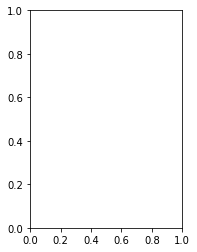

In [ ]:
fig = plt.figure()
ax1  = fig.add_subplot(121)
plt.plot(mercer_nj_both.index, [x - mercer_nj_both_aqi_average for x in mercer_nj_both['AQI']], label = "AQI")
plt.plot(mercer_nj_both.index, mercer_nj_both['retail_and_recreation_percent_change_from_baseline'], label = "mobility")
plt.legend(loc="upper left")
plt.show()

In [ ]:
x = mercer_nj_both.reset_index().index
y = mercer_nj_both.AQI
c = np.polyfit(x,y,1)
p = np.poly1d(c)
plt.plot(x, y, 'k', label="Data")
x_extrapolate = range(0,150)
plt.plot(x_extrapolate,p(x_extrapolate), 'b-',label="Polyfit")
plt.xlabel("Days")
plt.ylabel("AQI")
plt.legend(["Data","Model"])
plt.show()

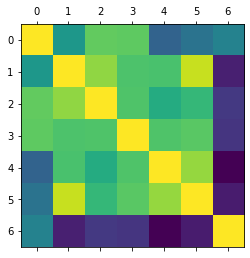

In [ ]:
#Simple correlation matrix
#Just the first column/row is interesting bc that is the AQI correlation to the mobility types
plt.matshow(mercer_nj_both[[
                            'AQI', 
                            'retail_and_recreation_percent_change_from_baseline', 
                            'grocery_and_pharmacy_percent_change_from_baseline',
                            'parks_percent_change_from_baseline',
                            'transit_stations_percent_change_from_baseline',
                            'workplaces_percent_change_from_baseline',
                            'residential_percent_change_from_baseline']].corr())
plt.show()

In [ ]:
@interact
def choose_nj_county(column1 = emissions[emissions['State Name'] == 'New Jersey']['county Name'].unique()):
    print('chosen: '+column1)

NameError: ignored

In [ ]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

def plot_nj_county(county_name):
    county_emissions = emissions[emissions['County'] == county_name]
    county_mobility = global_mobility[(global_mobility.country_region == 'United States')][(global_mobility.sub_region_1 == 'New Jersey')][global_mobility.sub_region_2 == county_name + ' County']
    
    county_mobility = county_mobility.rename(columns={'date':'Date'})
    #mercer_nj = mercer_nj_emissions.set_index('Date').join(mercer_nj_mobility.set_index('Date'))
    county = county_emissions.set_index('Date').join(county_mobility.set_index('Date'))
    county_both = county[county.country_region_code == 'US']
    county_both_aqi_average = sum(county_both[' AQI Value']) / len(county_both[' AQI Value'])
    plt.plot(county_both.index, [x - county_both_aqi_average for x in county_both[' AQI Value']], label = " AQI Value")
    plt.plot(county_both.index, county_both['retail_and_recreation_percent_change_from_baseline'], label = "mobility")
    plt.legend(loc="upper left")
    plt.show()

@interact
def choose_nj_county(county = emissions['County'].unique()):
    print('chosen: ' + county)
    plot_nj_county(county)

NameError: ignored